In [1]:
import numpy as np
import os
import torch
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_absolute_error
from matplotlib import gridspec
import seaborn as sns
import joblib


## 两个信噪比范围合成一个表

In [7]:
test_catalog5_50 = pd.read_csv("../../2_SpecTE/model_log/blending/5_50/catalog5_50.csv")
test_catalog50_999 = pd.read_csv("../../2_SpecTE/model_log/blending/50_999/catalog50_999.csv")

In [8]:
test_catalog5_50.shape

(9266, 58)

In [9]:
test_catalog50_999.shape

(14674, 58)

In [10]:
test_catalog = pd.concat([test_catalog5_50, test_catalog50_999], ignore_index=True)
test_catalog.shape

(23940, 58)

In [11]:
test_catalog.to_csv("./test_catalog.csv", index=False)
test_catalog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23940 entries, 0 to 23939
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   snrg             23940 non-null  float64
 1   Teff[K]          23940 non-null  float64
 2   Teff[K]_predict  23940 non-null  float64
 3   Teff[K]_err      23940 non-null  float64
 4   Logg             23940 non-null  float64
 5   Logg_predict     23940 non-null  float64
 6   Logg_err         23940 non-null  float64
 7   RV               23940 non-null  float64
 8   RV_predict       23940 non-null  float64
 9   RV_err           23940 non-null  float64
 10  FeH              23940 non-null  float64
 11  FeH_predict      23940 non-null  float64
 12  FeH_err          23940 non-null  float64
 13  MgH              23940 non-null  float64
 14  MgH_predict      23940 non-null  float64
 15  MgH_err          23940 non-null  float64
 16  SiH              23940 non-null  float64
 17  SiH_predict 

## 读取结果

In [2]:
# 读全部文件
label_name_list = ['Teff[K]', 'Logg', 'RV','FeH', 'CH', 'NH', 'OH', 'MgH', 'AlH', 'SiH', 'SH',
                   'KH', 'CaH', 'TiH', 'CrH','MnH', 'NiH','NaH', 'VH']
test_catalog = pd.read_csv("./test_catalog.csv")


# 分别提取 真实标签、预测标签、预测误差、真实误差
predicted_label_names = [x + '_predict' for x in label_name_list]
predicted_error_names = [x + '_err' for x in label_name_list]

true_label = test_catalog[label_name_list].values.astype(np.float32)
predict_label = test_catalog[predicted_label_names].values.astype(np.float32)
predict_err = test_catalog[predicted_error_names].values.astype(np.float32)

err_predict_true = predict_label - true_label
true_label.shape

(23940, 19)

In [3]:
predicted_error_names

['Teff[K]_err',
 'Logg_err',
 'RV_err',
 'FeH_err',
 'CH_err',
 'NH_err',
 'OH_err',
 'MgH_err',
 'AlH_err',
 'SiH_err',
 'SH_err',
 'KH_err',
 'CaH_err',
 'TiH_err',
 'CrH_err',
 'MnH_err',
 'NiH_err',
 'NaH_err',
 'VH_err']

In [ ]:
# 拼接几号
No2 = 6
model_name2 = model_list[No2]

# 读全部文件
path_model_2 = os.path.join(data_result_path,model_name2)
path_test_out_2 = os.path.join(path_model_2,"test_label_{}_out.csv".format(model_name2))
# df_test_out = pd.read_csv(data_result_path)
df_test_out2 = pd.read_csv(path_test_out_2)

# 分别提取 真实标签、预测标签、预测误差、真实误差
true_label_2 = df_test_out2[label_name_list].values.astype(np.float32)
predict_label_2 = df_test_out2[["%s_%s"%(model_name, name) for name in label_name_list]].values.astype(np.float32)
predict_err_2 = df_test_out2[["%s_%s_err"%(model_name, name) for name in label_name_list]].values.astype(np.float32)

true_label_2.shape

In [ ]:
# 进行拼接
true_label = np.vstack((true_label, true_label_2))
predict_label = np.vstack((predict_label, predict_label_2))
predict_err=np.vstack((predict_err, predict_err_2))
err_predict_true = predict_label - true_label
true_label.shape

## 统计参数

In [4]:
df_indicator = pd.DataFrame(index=label_name_list, columns=["μ", "σ", "MAE"])
for i , label_name in enumerate(label_name_list):
    true = true_label[:, i]
    predict = predict_label[:, i]
    err = err_predict_true[:, i]
    bias = np.mean(err) # 残差均值
    scatter = np.std(err)  # 残差标准差
    mae = mean_absolute_error(true, predict) # 平均绝对误差
    df_indicator.at[label_name, "μ"] = bias
    df_indicator.at[label_name, "σ"] = scatter
    df_indicator.at[label_name, "MAE"] = mae
# df_indicator.to_csv("./pdf/result_indicator/df_indicator_{}.csv".format(model_name))
df_indicator

,μ,σ,MAE
Teff[K],-0.197937,90.231087,45.095745
Logg,0.0,0.159631,0.080246
RV,-0.022696,9.884436,3.870888
FeH,-0.000552,0.064228,0.036682
CH,-0.000233,0.08089,0.048257
NH,-0.000927,0.171172,0.098347
OH,-0.000334,0.096442,0.062337
MgH,-0.000561,0.063303,0.038901
AlH,0.000494,0.087806,0.053271
SiH,-0.00038,0.065311,0.040091


## 概率密度残差图

In [15]:
def residual_distribution_Abundance(y_test, y_pred, param_name='C', name=None,lims=None,ditribution_lims = (-2, 2),s=5,cmap='plasma'):
    
    # 设置Matplotlib图形样式
    plt.rcParams['axes.facecolor']='white' # 设置图表背景颜色为白色
    sns.set_style("ticks")    # 设置图表样式为带有刻度线
    plt.rcParams['axes.grid']=True  # 启用网格线
    plt.rcParams['grid.color']='gray' # 网格线颜色设置为灰色
    plt.rcParams['grid.alpha']='0.3' # 设置网格线的透明度
    plt.rc('text', usetex=False)   # 不使用TeX排版
    plt.rc('font', family='serif') # 设置字体为衬线字体
    
    # 设置x和y轴标签
    x_lab = 'APOGEE'
    y_lab = 'Prediction'
    
    # 计算核密度估计
    x, y = y_test, y_pred 
    xy = np.vstack([x,y])      # 垂直堆叠在一起
    z = gaussian_kde(xy)(xy)   # 计算在每个数据点的密度值
    z = z / z.max()      
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]   # 按照密度重新排列
    resid = y - x        # 残差
    bias = np.mean(resid) # 残差均值
    scatter = np.std(resid)  # 残差标准差
    mae = mean_absolute_error(y, x) # 平均绝对误差
    
    # 残差映射
    #cmap='plasma'
    # 'gray'  viridis  jet magma
    
    # 设置图形的x轴和y轴范围
    if not lims:
        lims = (min(x), max(x)) 
    ditribution_lims = ditribution_lims  
    xticks = []  
    
    # 创建图形(x(min), x(max))
    fig = plt.figure(figsize=(8, 2.4))
    gs = gridspec.GridSpec(1, 1)  # 创建一个 1x1 的网格规格对象。这个网格规格对象用于定义图形中子图的排列方式
    
    # 创建子图
    ax0 = plt.subplot(gs[0, 0])
    points = ax0.scatter(x, resid, c=z, s=s, cmap=cmap) # c=着色依据 s = 散点大小 cmap = 颜色
    
    # 设置标签和标题
    # ax0.set_xlabel('[%s/H]_%s(dex)' % (param_name, 'GALAH'), fontsize=25)
    ax0.set_xlabel('%s(dex)' % (param_name), fontsize=25)
    ax0.set_ylabel('$\Delta$ %s' % (param_name), fontsize=25)
     
    # 设置刻度标签大小和样式
    ax0.tick_params(labelsize=10, width=1, length=10)
    ax0.set_xlim(lims)
    ax0.set_ylim(ditribution_lims)
    
    # 添加一致线
    ax0.plot(lims, [0,0], 'k--', lw=2)
    
    # 在图中添加文本框，显示均值、标准差和MAE
    bbox_props = dict(boxstyle="square, pad=0.3", fc="w", ec="k", lw=0.75)
    # 0.14, 0.425,          0.2, 0.25,
    plt.figtext(0.15, 0.44, 
                    '$\mu$=' + '{0:.3f}'.format(bias) + ' $\sigma$=' + '{0:.3f}'.format(scatter)+ ' MAE=' + '{0:.3f}'.format(mae),
                    fontsize=14, bbox=bbox_props)
    plt.tick_params(labelsize=14)
    
    # Add a text box showing the statistics
    text_str = '$\mu$=' + '{0:.3f}'.format(bias) + ' $\sigma$=' + '{0:.3f}'.format(scatter) + ' MAE=' + '{0:.3f}'.format(mae)
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.72)
    ax0.text(text_position_x, text_position_y, text_str, ha='right', va='top', fontsize=12, bbox=bbox_props)

    
    # 调整图形布局
    plt.tight_layout()
    
    #保存图片
    if name:
        path = './pdf/residual/'+ name
        if not os.path.exists(path):
            os.makedirs(path)
        pdf_path = path + '/' + param_name + 'H_residual.pdf'
        plt.savefig(pdf_path)
        png_path = path + '/' + param_name + 'H_residual.png'
        plt.savefig(png_path)

In [16]:
true_label[:, 3]

array([-0.028293, -0.14538 , -0.19956 , ..., -0.46057 , -0.073622,
        0.10246 ], dtype=float32)

NameError: name 'text_position_x' is not defined

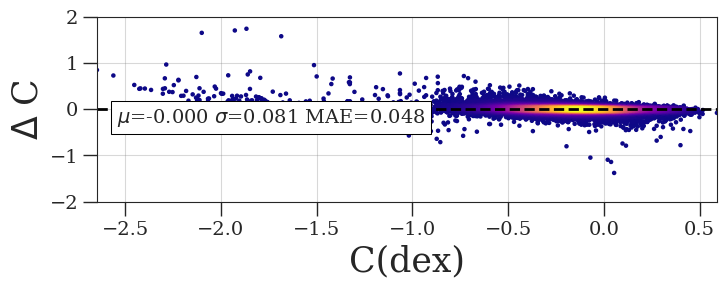

In [18]:
# residual_distribution_Abundance(true, predict, param_name='C', lims=(-1,0.5),ditribution_lims=(-2,2))  # 金属丰度
# residual_distribution_Abundance(true, predict, param_name='C',lims=(3700,7000),ditribution_lims=(-1500,1500))  # Teff
# residual_distribution_Abundance(true, predict, param_name='C',ditribution_lims=(-2,2))  # logg
true = true_label[:,4]
predict = predict_label[:, 4]
residual_distribution_Abundance(true, predict, param_name='C',name='try',lims = None ,ditribution_lims=(-2,2))  # logg

NameError: name 'text_position_x' is not defined

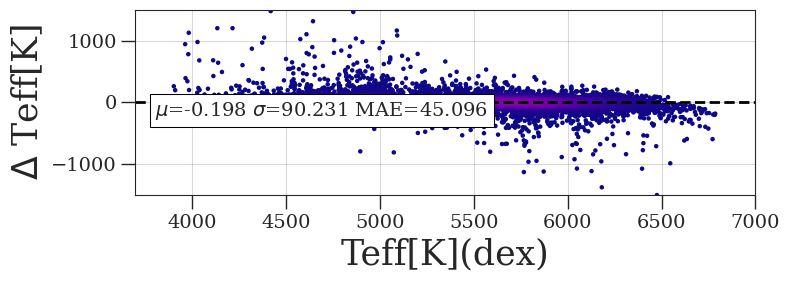

In [19]:
default_arg = {
    'Teff[K]':[(3700,7000),(-1500,1500)],
    'Logg':[(0,5),(-2,2)],
    'RV':[(-500,+500),(-10,10)],
    'CH':[None,(-2,2)], 
    'NH':[None,(-2,2)], 
    'OH':[None,(-2,2)], 
    'MgH':[None,(-2,2)], 
    'AlH':[None,(-2,2)], 
    'SiH':[None,(-2,2)], 
    'SH':[None,(-2,2)],
    'KH':[None,(-2,2)], 
    'CaH':[None,(-2,2)], 
    'TiH':[None,(-2,2)], 
    'CrH':[None,(-2,2)],
    'MnH':[None,(-2,2)], 
    'FeH':[None,(-2,2)], 
    'NiH':[None,(-2,2)],
    'NaH':[None,(-2,2)],
    'VH':[None,(-2,2)],
}

for i , label_name in enumerate(label_name_list):
    true = true_label[:, i]
    predict = predict_label[:, i]
    residual_distribution_Abundance(true, predict,name="try", param_name=label_name,lims=default_arg[label_name][0],
                                    ditribution_lims=default_arg[label_name][1])  


# 所有参数一个大图

In [5]:
def residual_distribution_Abundance(y_test, y_pred,ax0, param_name='C', name=None,lims=None,ditribution_lims = (-2, 2),s=5,cmap='plasma'):
    
    # 设置Matplotlib图形样式
    plt.rcParams['axes.facecolor']='white' # 设置图表背景颜色为白色
    sns.set_style("ticks")    # 设置图表样式为带有刻度线
    plt.rcParams['axes.grid']=True  # 启用网格线
    plt.rcParams['grid.color']='gray' # 网格线颜色设置为灰色
    plt.rcParams['grid.alpha']='0.3' # 设置网格线的透明度
    plt.rc('text', usetex=False)   # 不使用TeX排版
    plt.rc('font', family='serif') # 设置字体为衬线字体
    
    # 设置x和y轴标签
    x_lab = 'APOGEE'
    y_lab = 'Prediction'
    
    # 计算核密度估计
    x, y = y_test, y_pred 
    xy = np.vstack([x,y])      # 垂直堆叠在一起
    z = gaussian_kde(xy)(xy)   # 计算在每个数据点的密度值
    z = z / z.max()      
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]   # 按照密度重新排列
    resid = y - x        # 残差
    bias = np.mean(resid) # 残差均值
    scatter = np.std(resid)  # 残差标准差
    mae = mean_absolute_error(y, x) # 平均绝对误差
    

    # 设置图形的x轴和y轴范围
    if not lims:
        lims = (min(x), max(x)) 
    ditribution_lims = ditribution_lims  
    xticks = []  
    
    # 画点
    points = ax0.scatter(x, resid, c=z, s=s, cmap=cmap) # c=着色依据 s = 散点大小 cmap = 颜色
    
    # 设置标签和标题
    # ax0.set_xlabel('[%s/H]_%s(dex)' % (param_name, 'GALAH'), fontsize=25)
    ax0.set_xlabel('%s' % (param_name), fontsize=25)
    ax0.set_ylabel('$\Delta$ %s' % (param_name), fontsize=25)
     
    # 设置刻度标签大小和样式
    ax0.tick_params(labelsize=15, width=1, length=10)
    ax0.set_xlim(lims)
    ax0.set_ylim(ditribution_lims)
    
    # 添加一致线
    ax0.plot(lims, [0,0], 'k--', lw=2)
    
    

    # 在图中添加文本框，显示均值、标准差和MAE
    bbox_props = dict(boxstyle="square, pad=0.3", fc="w", ec="k", lw=1)
    # 0.0, 0.35
    ax0.text(0.03, 0.25, '$\mu$=' + '{0:.3f}'.format(bias) + ' $\sigma$=' + '{0:.3f}'.format(scatter) + ' MAE=' + '{0:.3f}'.format(mae), 
            fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, bbox=bbox_props)
    
    #plt.colorbar(points, ax=ax, orientation='vertical')  # 之前这个导致pdf为空白
    cbar = plt.colorbar(points, ax=ax0, orientation='vertical',)  # 显示颜色条
    cbar.ax.tick_params(labelsize=12)  # 刻度字体大小
    # cbar.set_label('$\mathrm{[Fe/H]}$ from SpecTE (dex)', size=20)
    # 调整图形布局
    plt.tight_layout()
    


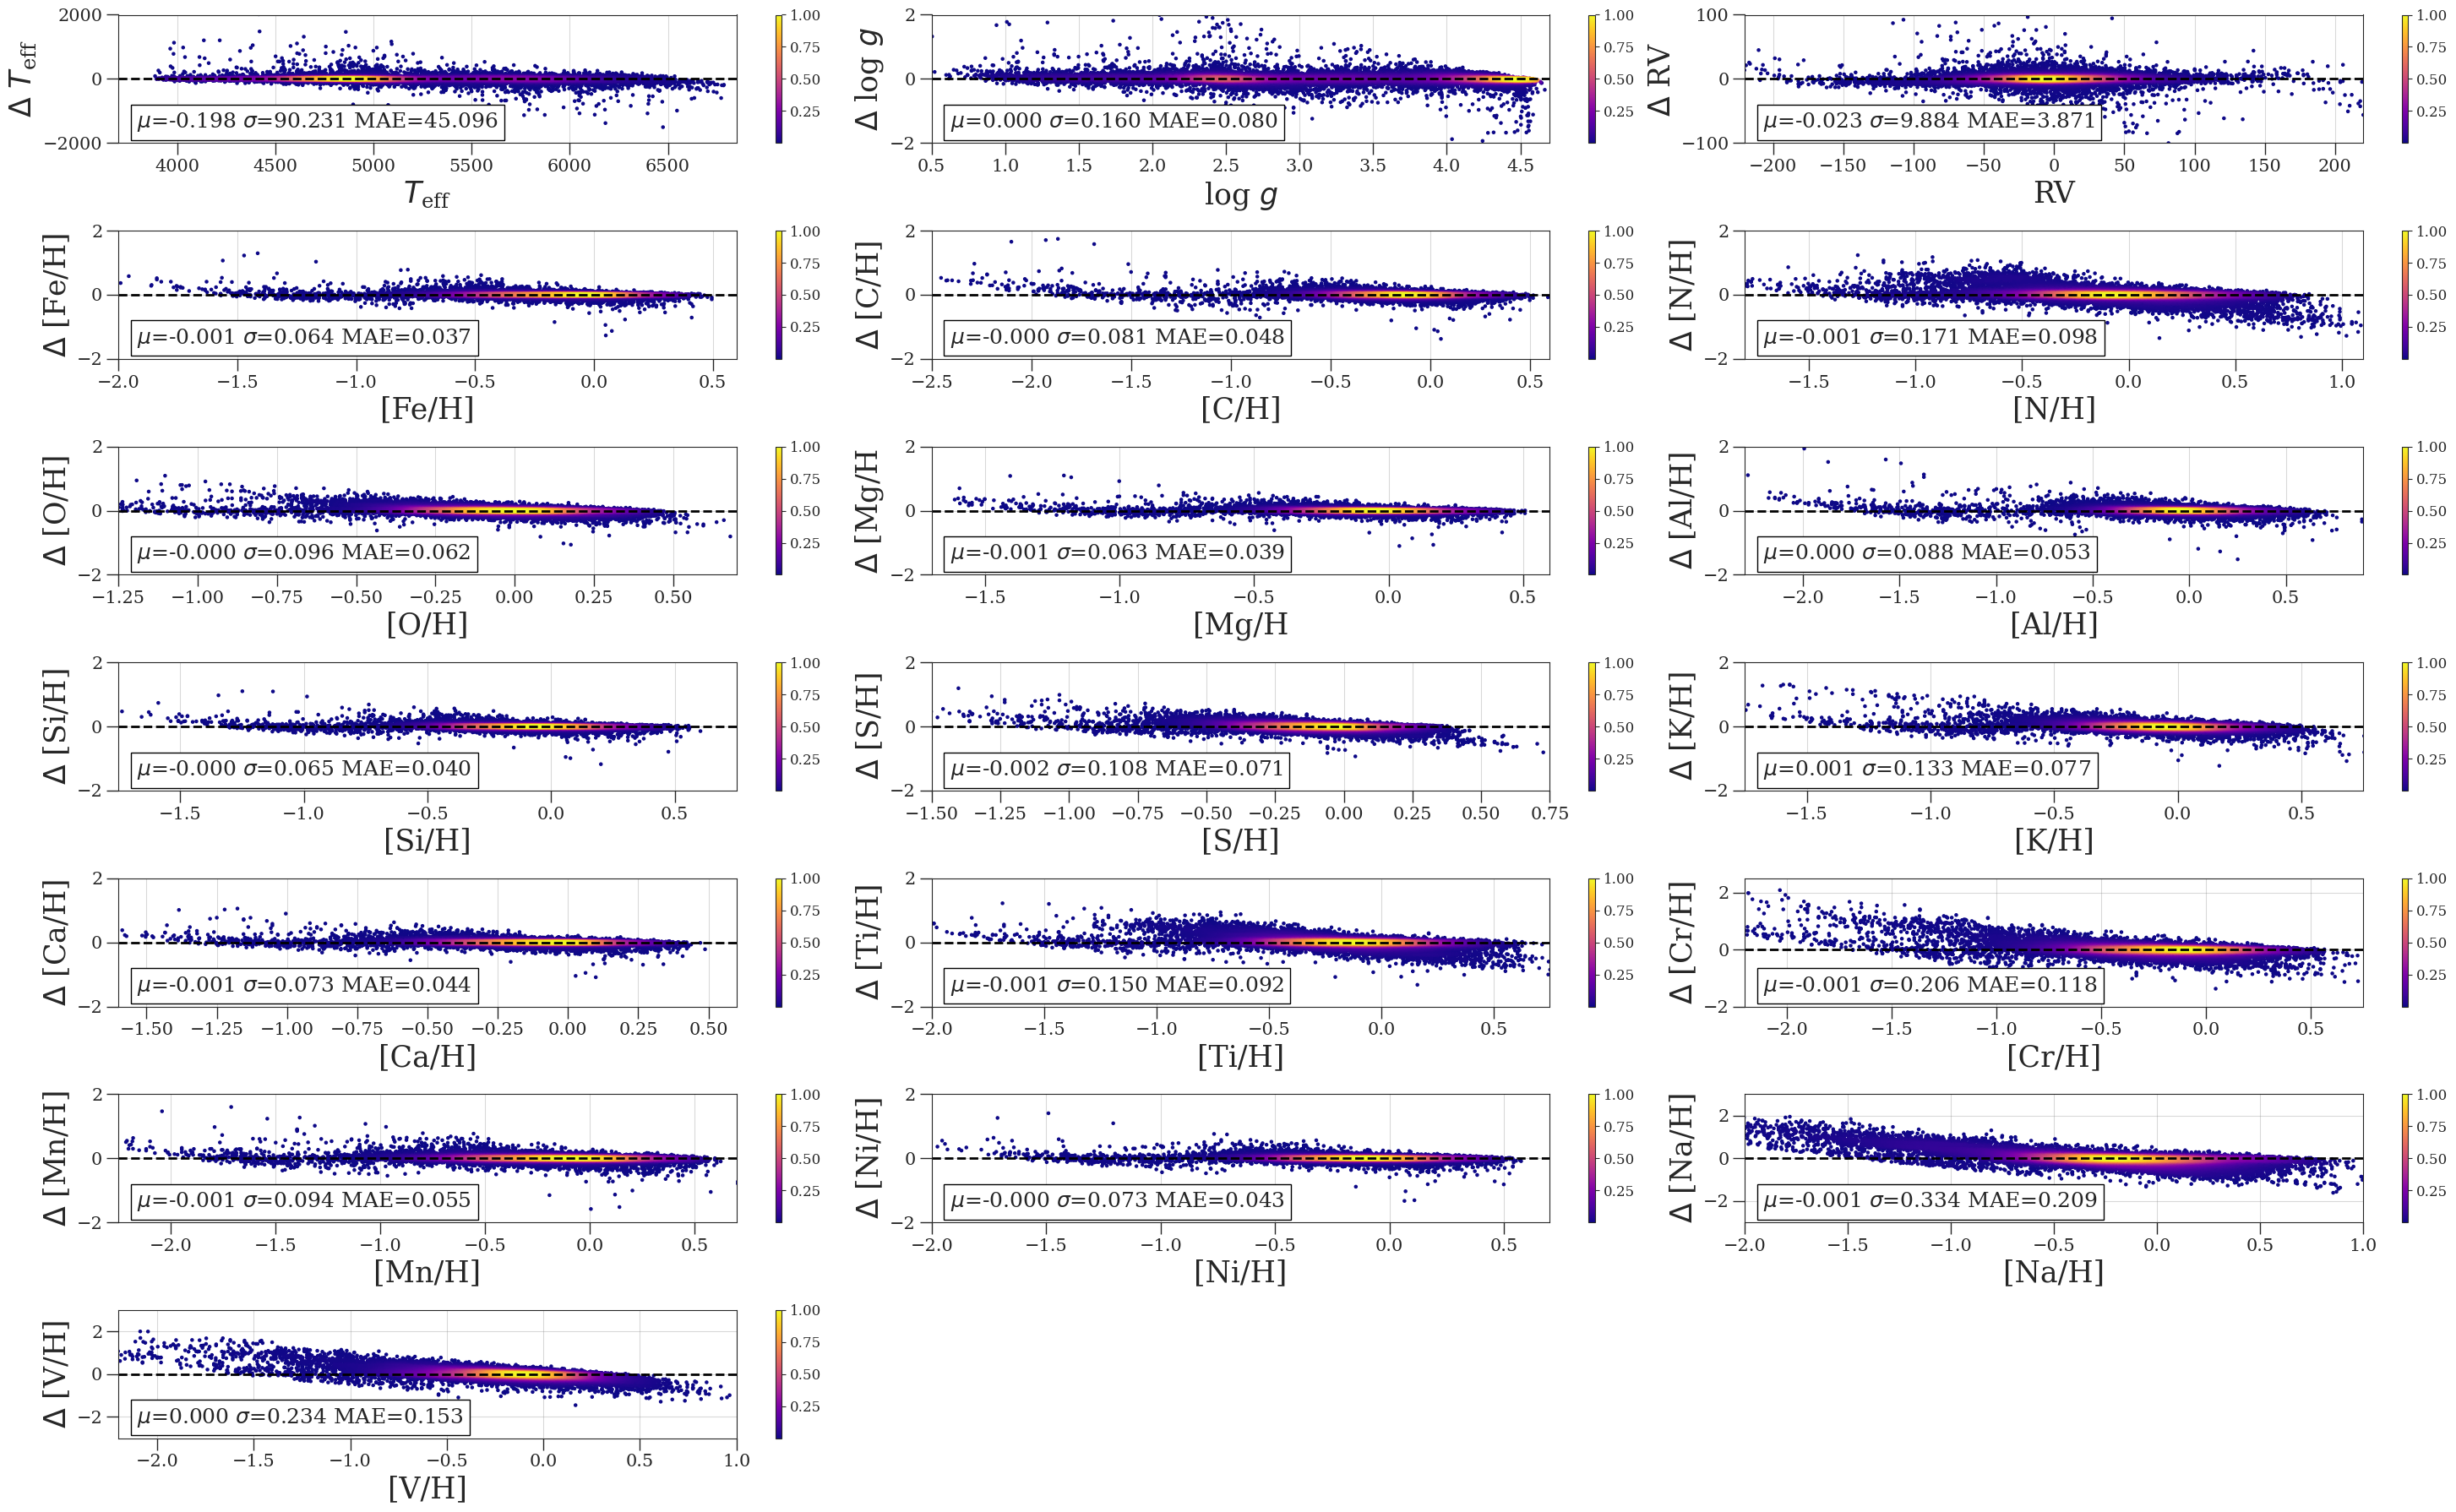

In [7]:
default_arg = {
    'Teff[K]':[(3700,6850),(-2000,2000)],
    'Logg':[(0.5,4.7),(-2,2)],
    'RV':[(-200,+200),(-100,100)],
    'CH':[(-2.5,0.6),(-2,2)], 
    'NH':[(-1.8,1.1),(-2,2)], 
    'OH':[(-1.25,0.7),(-2,2)], 
    'MgH':[(-1.7,0.6),(-2,2)], 
    'AlH':[(-2.3,0.9),(-2,2)], 
    'SiH':[(-1.75,0.75),(-2,2)], 
    'SH':[(-1.5,0.75),(-2,2)],
    'KH':[(-1.75,0.75),(-2,2)], 
    'CaH':[(-1.6,0.6),(-2,2)], 
    'TiH':[(-2,0.75),(-2,2)], 
    'CrH':[(-2.2,0.75),(-2,2.5)],
    'MnH':[(-2.25,0.7),(-2,2)], 
    'FeH':[(-2,0.6),(-2,2)], 
    'NiH':[(-2,0.7),(-2,2)],
    'NaH':[(-2,1.0),(-3,3)],
    'VH':[(-2.2,1.0),(-3,3)],
}

label_name_dir = {
    'Teff[K]':r'$T_{\mathregular{eff}}$ ',
    'Logg':'log $g$',
    'RV':'RV',
    'CH':'[C/H]', 
    'NH':'[N/H]', 
    'OH':'[O/H]', 
    'MgH':'[Mg/H', 
    'AlH':'[Al/H]', 
    'SiH':'[Si/H]', 
    'SH':'[S/H]',
    'KH':'[K/H]', 
    'CaH':'[Ca/H]', 
    'TiH':'[Ti/H]', 
    'CrH':'[Cr/H]',
    'MnH':'[Mn/H]', 
    'FeH':'[Fe/H]', 
    'NiH':'[Ni/H]',
    'NaH':'[Na/H]',
    'VH':'[V/H]',
}

# 支持latex
plt.rcParams.update({
    "text.usetex": False
})


# 创建一个大的图形，适当调整figsize参数以适应内容
# fig = plt.figure(figsize=(30, 15))
fig = plt.figure(figsize=(30, 18))

# 定义一个列表，包含每行的子图数量
subplot_layout = [3, 3, 3, 3, 3, 3,1]

# 创建一个计数器来追踪当前子图的位置
subplot_index = 1

# 循环遍历每一行的布局设置
for row in subplot_layout:
    for _ in range(row):
        ax = fig.add_subplot(7, 3, subplot_index)  # 第一个参数是行数，第二个是列数，第三个是子图编号
        if subplot_index <= len(label_name_list):
            label_name = label_name_list[subplot_index - 1]
            true = true_label[:, subplot_index - 1]
            predict = predict_label[:, subplot_index - 1]
            lims = default_arg[label_name][0]
            ditribution_lims = default_arg[label_name][1]
            residual_distribution_Abundance(true, predict, ax, param_name=label_name_dir[label_name], lims=lims, ditribution_lims=ditribution_lims)
        subplot_index += 1

# 调整布局并显示图形
plt.tight_layout()

# 检查并创建存储路径
path = './pdf/residual/'
if not os.path.exists(path):
    os.makedirs(path)

# 保存图形为PDF和PNG文件
pdf_path = path + '/' + 'residual.pdf'
plt.savefig(pdf_path)

png_path = path + '/' + 'residual.png'
plt.savefig(png_path)

plt.show()